# Citi Bikes
## Intro

The Citi Bike bicycle sharing system was first proposed in 2008 as part of the New York City Department of Transportation's (NYCDOT) plan to reduce emissions as well as traffic congestion in NYC. As part of its study, NYCDOT found that over half of all auto trips within the city were fewer than 3 miles - a distance that could be more efficiently traversed on bicycle. The initiative was proposed to complement the city’s ongoing effort to incentivize bikes as a means of transport by investing in protected bike lanes, a measure implemented in other major cities. After setbacks from logistical issues, including bicycle and station damage from Hurricane Sandy, Citi Bike opened in May 2013 with over 300 stations and 6,000 bikes.

This analysis gives an overview of Citi Bike usage in New York City using data from July 2013 through February 2020. The analysis includes rider demographics as well as yearly, monthly, weekly, and daily trends. We also attempt to identify users riding together, offer statistical backing for this classification, and highlight the demographic and weekly trend differences between this set of riders and the overall dataset. We then use the Facebook Prophet package for time series analysis and try to explain variation in daily volume using a variety of regressors from historical weather data. We use rider data from Google’s BigQuery database as well as data from the Citi Bike AWS account, and historical weather data from the NOAA. For readability, chart code has been wrapped in functions and is referenced from funcs.py file. Queries for Google's database and webscraping code can be seen in the dataprep file. 

In [1]:
# basic packages
import pandas as pd
import numpy as np
import warnings
from calendar import day_abbr

# visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objs as go
from plotly.subplots import make_subplots
from plotly.graph_objs import *

# FB prophet for time series
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

# chart udf's
import funcs as f

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
mapbox_access_token = "pk.eyJ1IjoicGxvdGx5bWFwYm94IiwiYSI6ImNqdnBvNDMyaTAxYzkzeW5ubWdpZ2VjbmMifQ.TXcBE-xg9BFdV2ocecc_7g"

# Importing and Combining Data from BigQuery & Citi Bike AWS

In [3]:
# importing processed data

df = pd.read_csv('./data/processed/combined.csv')
df_citi = pd.read_csv('./data/citi/combined.csv').drop(columns = ['Unnamed: 0'])

df = df.append(df_citi)
df['starttime'] = pd.to_datetime(df['starttime'], format = '%Y-%m-%d %H:%M')
df['stoptime'] = pd.to_datetime(df['stoptime'], format = '%Y-%m-%d %H:%M')

df = df.set_index('starttime')

In [4]:
# gender and age 

df.loc[df['gender'] == 0, 'gender'] = 'unknown'
df.loc[df['gender'] == 1, 'gender'] = 'male'
df.loc[df['gender'] == 2, 'gender'] = 'female'

df['age'] = df.index.year - df['birth_year'] + 1

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
print('{:,.0f} datapoints'.format(df.shape[0]))
df.head()

9,372,320 datapoints


,bikeid,birth_year,customer_plan,end_station_id,end_station_latitude,end_station_longitude,end_station_name,gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,stoptime,tripduration,usertype,age
starttime,,,,,,,,,,,,,,,,
2013-12-24 15:50:04,17993,1951.0,NaN,271.0,40.685282,-73.978058,Ashland Pl & Hanson Pl,male,439.0,40.726281,-73.989780,E 4 St & 2 Ave,2013-12-24 16:19:44,1780,Subscriber,63.0
2013-11-18 18:32:00,16337,1945.0,NaN,3002.0,40.711512,-74.015756,South End Ave & Liberty St,male,79.0,40.719116,-74.006667,Franklin St & W Broadway,2013-11-18 18:42:46,646,Subscriber,69.0
2013-08-20 07:42:02,19632,1950.0,NaN,477.0,40.756405,-73.990026,W 41 St & 8 Ave,male,352.0,40.763406,-73.977225,W 56 St & 6 Ave,2013-08-20 07:53:06,664,Subscriber,64.0
2013-11-21 13:26:07,20065,1951.0,NaN,316.0,40.709560,-74.006536,Fulton St & William St,male,195.0,40.709056,-74.010434,Liberty St & Broadway,2013-11-21 13:28:53,166,Subscriber,63.0
2013-09-01 12:16:59,17095,1952.0,NaN,147.0,40.715422,-74.011220,Greenwich St & Warren St,male,363.0,40.708347,-74.017134,West Thames St,2013-09-01 12:26:46,587,Subscriber,62.0


We've downsampled 10x for processing efficiency

# Demographics and Trends

### Age and Gender Demos
- Women represent 1/4 of the riders and are slightly younger than their male counterparts
- ~9% of the data have unknown gender

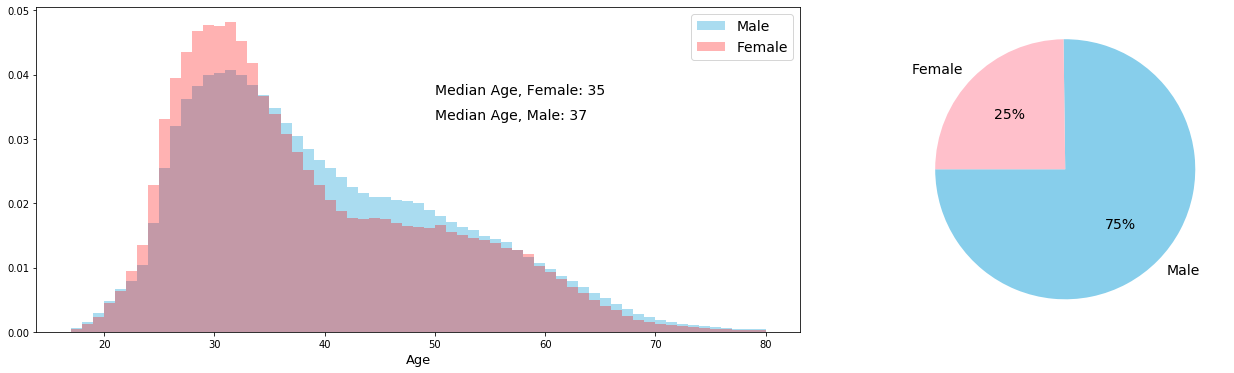

In [6]:
f.demo_charts(df)

### YOY Growth and Annual & Weekly Trends
- Steady YOY growth
- The cold is the deterrent we'd expect
- Weekdays see the majority of use

<Figure size 432x288 with 0 Axes>

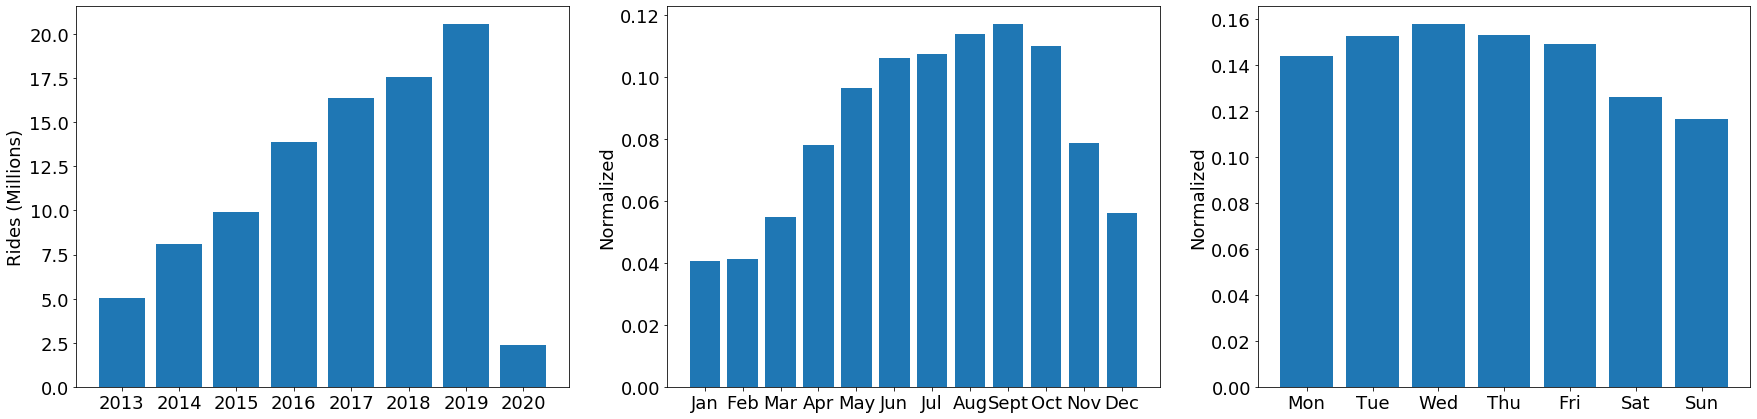

In [7]:
f.trend_charts(df)

### Daily and Hourly Trends
- Weekday rides peak during commute hours - commuters account for 41% of rider volume 
- Weekend rides represent 12% of riders - people are out and about during hours they'd otherwise be working

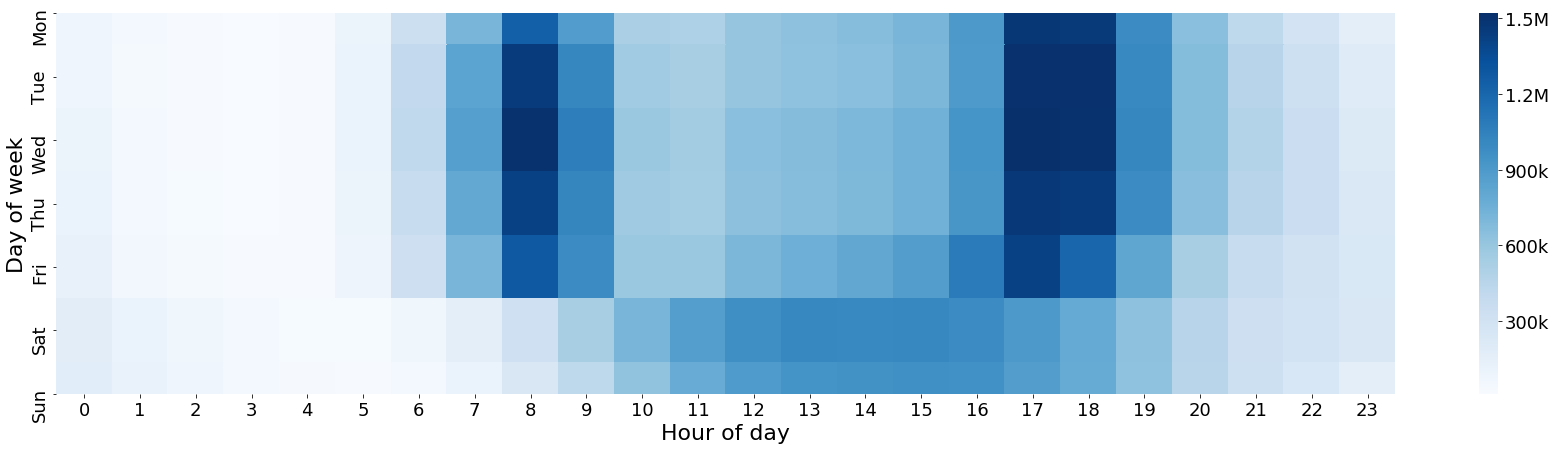

In [8]:
f.time_heatmap(df)

In [9]:
mask_comm = (df.index.hour.isin([7, 8, 9, 17, 18, 19])) & (df.index.weekday < 6)
mask_wknd = (df.index.weekday > 5)

print('Commute: {:.0f}%'.format(100 * df[mask_comm].shape[0] / df.shape[0]))
print('Weekend: {:.0f}%'.format(100 * df[mask_wknd].shape[0] / df.shape[0]))

Commute: 41%
Weekend: 12%


### Commuters
Commuters share very similar age and gender demos with the general rider population 

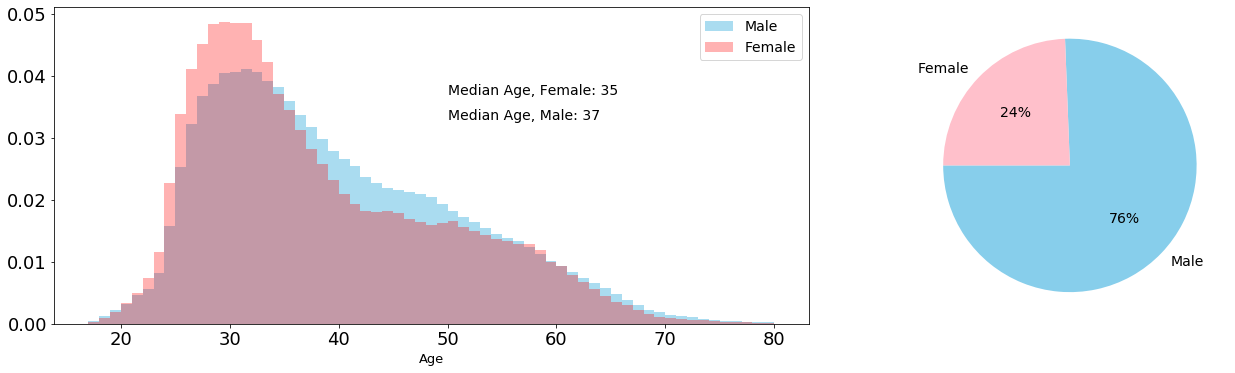

In [10]:
f.demo_comm(df)

### Weekenders
We see a slight uptick in the female weekender population compared to the general pop (28% vs. 25%)

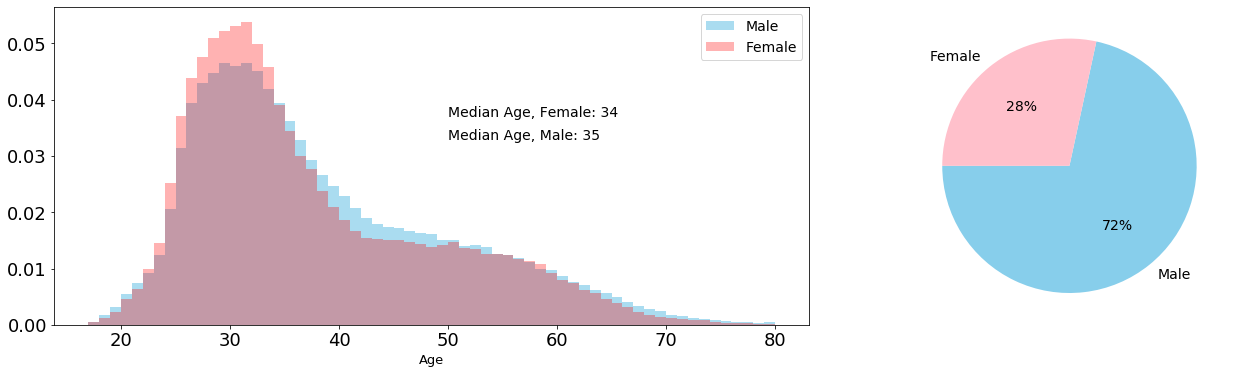

In [11]:
f.demo_weeknd(df)

### Who's Riding in the Middle of the Night*?

*Night = 11 PM - 5 AM


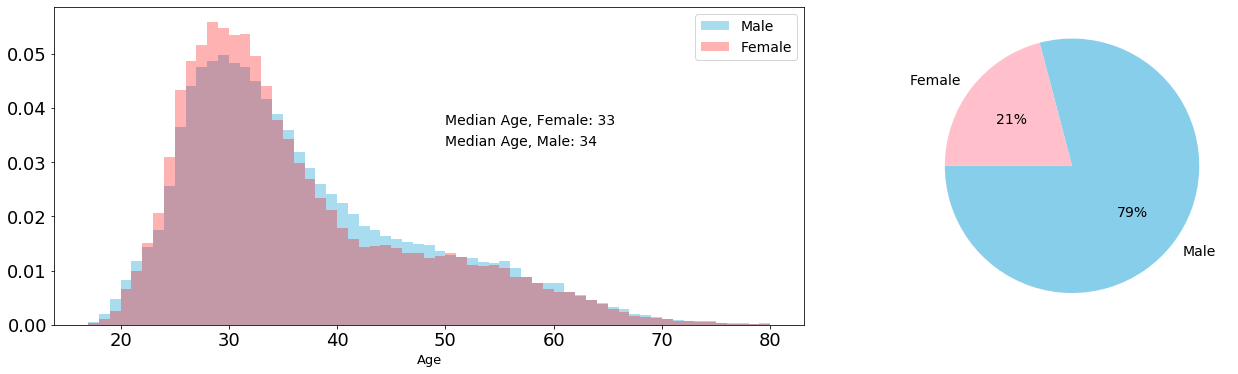

In [12]:
f.night_riders(df)

Baby Boomers cruising the city at night seems a little odd, looks like there may be a fair amount of misreported birth years

# Bike Ride for Two 🙋‍🙋‍♂️ 

#### We're defining two individuals as riding together if the following conditions are met:

- The two start and end at the same station
- The two start their trips within 30 seconds of eachother
- The two end their trips within 30 seconds of eachother
- Query refelcting these conditions can be seen in data_prep file

#### We'll also assess whether these are reasonable critera for concluding that riders are together

In [13]:
# loading in data
df_r = pd.read_csv('./data/initial/bike_rides.csv')

for col in ['a_start', 'b_start', 'a_stop', 'b_stop']:
    df_r[col] = pd.to_datetime(df_r[col], format = '%Y-%m-%d %H:%M')

df_r.set_index('a_start', inplace = True)

In [14]:
# creating age columns columns for the riders
c = {'a_age' : 'a_yob', 'b_age' : 'b_yob'}

for col_new, col in c.items():
    df_r[col_new] = df_r.index.year - df_r[col] + 1

In [15]:
df_r.head()

,start_station_id,end_station_id,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,b_start,a_stop,b_stop,a_duration,b_duration,a_yob,a_gender,b_yob,b_gender,a_age,b_age
a_start,,,,,,,,,,,,,,,,,
2017-07-30 12:21:16.000,3142,3142,40.761227,-73.960940,40.761227,-73.960940,2017-07-30 12:20:51.000,2017-07-30 12:31:27.000,2017-07-30 12:31:27.000,611,635,2000,male,1999,male,18,19
2017-04-23 16:20:21.000,3356,342,40.774667,-73.984706,40.717400,-73.980166,2017-04-23 16:20:20.000,2017-04-23 17:02:35.000,2017-04-23 17:02:08.000,2534,2507,1957,female,1956,male,61,62
2017-04-09 18:57:21.000,439,161,40.726281,-73.989780,40.729170,-73.998102,2017-04-09 18:57:04.000,2017-04-09 19:02:17.000,2017-04-09 19:02:18.000,296,314,1961,female,1956,male,57,62
2018-01-20 11:35:05.407,499,3143,40.769155,-73.981918,40.776321,-73.964274,2018-01-20 11:35:04.202,2018-01-20 11:49:06.820,2018-01-20 11:49:04.747,841,840,2000,female,1999,male,19,20
2014-06-07 13:12:18.000,229,320,40.727434,-73.993790,40.717571,-74.005549,2014-06-07 13:11:58.000,2014-06-07 13:20:55.000,2014-06-07 13:20:48.000,517,530,1950,female,1950,male,65,65


In [16]:
print('Tandem Rider data points: {:,.0f}'.format(df_r.shape[0]))

Tandem Rider data points: 912,258


### Women tend to ride with friends
- The age distribution shape is similar to the population's
- However, women represent 37% of riders in this group versus 25% of overall population

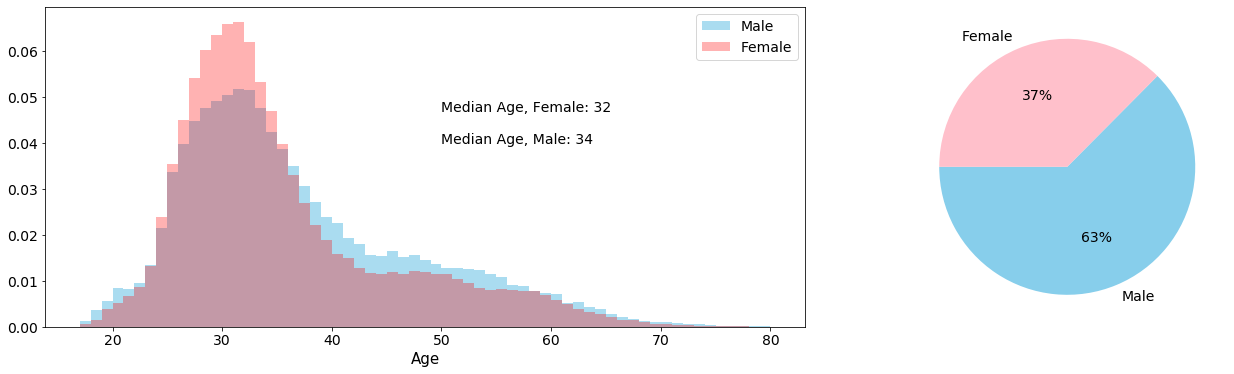

In [17]:
f.demo_charts_r(df_r)

### Weekend Afternoons are Peak Hours for Tandem Riders

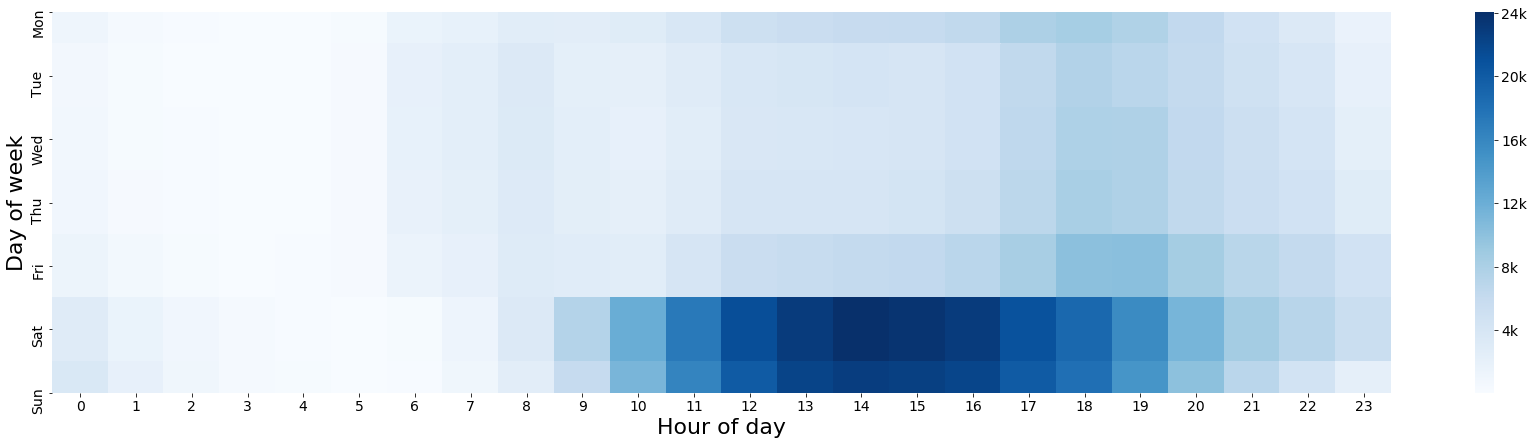

In [18]:
f.time_heatmap_r(df_r)

In [19]:
u_mask = (df_r.a_gender != 'unknown') & (df_r.b_gender != 'unknown')
ff_mask = (df_r.a_gender == 'female') & (df_r.b_gender == 'female')
mm_mask = (df_r.a_gender == 'male') & (df_r.b_gender == 'male')

ff = 100 * df_r[ff_mask].shape[0] / df_r[u_mask].shape[0]
mm = 100 * df_r[mm_mask].shape[0] / df_r[u_mask].shape[0]
fm = 100 - (ff + mm)

print('Female / Female Riders: {:.0f}%'.format(ff))
print('Male / Male Riders: {:.0f}%'.format(mm))
print('Female / Male Riders: {:.0f}%'.format(fm))

Female / Female Riders: 6%
Male / Male Riders: 31%
Female / Male Riders: 63%


# Hypothesis Testing
### Are These Riders Rogether or Are We Observing ~1M Coincidences?

Happily we can test this. Let's assume we're observing a coincidence and the pairs in this dataset are strangers

If the pairs are strangers, we'd expect the following when comparing ages of the two:
- E[Age Differece] = E[X1 - X2] = E[X1] - E[X2] = 0
- Var[Age Difference]* = Var[X1 - X2] = Var[X1] + Var[X2] = 272 (see variance calculation below)

On the other hand, if the pair of riders knew each other, we'd expect that the pairs would tend to be peers, and relitively close in age. If this were true, we'd see a much tighter distribution than a distribution of randomly selected pairs

*In our difference-in-age variance calculation, we've assumed X1 and X2 don't covary - we'll examine this later


In [20]:
# population age mean and variance
mask = (df['age'] <= 80)

age_mean = df[mask].age.mean()
age_var = df[mask].age.var()
print('E[Age]: {:.0f}, Var[Age]: {:.0f}'.format(age_mean, age_var))

E[Age]: 39, Var[Age]: 136


### Comparing the Observed and Expected Age Difference Distributions
Visually, we're rejecting the null hypothesis that these pairs are strangers

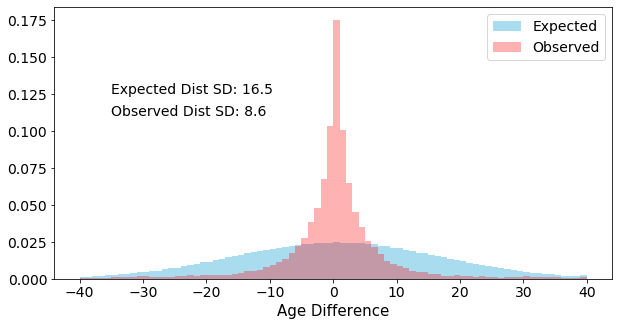

In [21]:
f.dist_oe(df_r, age_mean, age_var)

It's possible that the ages are more tightly packed in our riders dataset because the pairs are taking bikes from the same dock. 
<br>
Maybe we're only measuring the fact that these riders are likely from the same neighborhood, and perhaps ages tend to cluster within neighborhoods. 
<br>
A variety of other confounders are possible that could cause ages to covary.


We'll now randomly sample pairs from the same dock from our overall dataset, and compare their ages. The number of pairs sampled from each dock will be proportionate to each dock's representation in the dataset.

In [22]:
# dock df

dock_rides = pd.DataFrame(df.start_station_id.value_counts())
dock_rides.rename(columns = {'start_station_id' : 'rides'}, inplace = True)

dock_rides['pct'] = df.start_station_id.value_counts(normalize = True)
dock_rides['sample_ct'] = np.ceil(dock_rides.pct * df_r.shape[0])

# filtering out docks with fewer than 50 rides 
mask = (dock_rides.rides >= 50)
dock_rides = dock_rides[mask]

The table shows the number of sampled pairs to be drawn from each dock

In [23]:
dock_rides.head()

,rides,pct,sample_ct
519.0,89000,0.009496,8664.0
497.0,67517,0.007204,6572.0
435.0,63951,0.006824,6225.0
402.0,60185,0.006422,5859.0
426.0,59696,0.006370,5811.0


In [24]:
# sampling loop
# gender unknown was discovered to be assigned age = 50
# filtering out to remove a bias in number of age_diff equal to zero

mask = (df.age <= 80) & (df.gender != 'unknown')
samp_df = df[mask & (df.age.notnull())]
sample = []

j = 0

for index in dock_rides.index:
    
    size = dock_rides.loc[index].sample_ct.astype(int)
    loop_df = samp_df[samp_df['start_station_id'] == index]
    i = 0
    while i in range(size):
        
#         sampling with replacement is way faster and produced the same distribution
        pair = np.random.choice(loop_df.age, size = 2, replace = True)
        sample.append(pair)

        i += 1
    j += 1
    
df_s = pd.DataFrame(sample)
df_s['diff'] = df_s[0] - df_s[1]
df_s.rename(columns = {0 : 'person_a', 1 : 'person_b'}, inplace = True)    

In [25]:
print('{:,.0f}'.format(df_s.shape[0]))
df_s.head()

912,566


,person_a,person_b,diff
0,29.0,26.0,3.0
1,36.0,47.0,-11.0
2,50.0,25.0,25.0
3,26.0,51.0,-25.0
4,30.0,30.0,0.0


### Comparing Our Theoretical, Sampled, and Observed Distributions

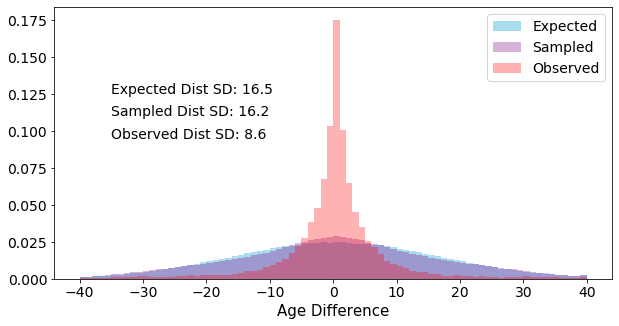

In [26]:
f.dist_oes(df_r, df_s, age_mean, age_var)

Distribution generated with theory is very similar to our sampled distribution

### Full disclosure, the sampled dataset doesn't quite have a normal shape:
<br>
I tried sampling without replacement, and filtering out docks with fewer rides overall
<br>
to reduce the chance of having samples with the same rider (and thus same age) to correct the
<br>
non-Gaussian shape but haven't quite cracked the code. Maybe it has something to do with the 
<br>
asymmetric overall age distribution.

### Empirical & Theoretical Distributions

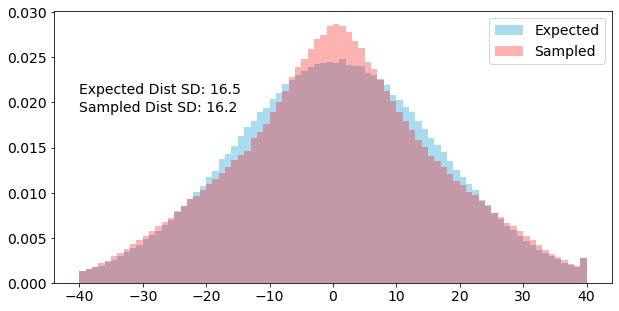

In [27]:
e = np.random.normal(age_mean - age_mean, np.sqrt(age_var + age_var), df_r.shape[0]).round()

fig, (ax1) = plt.subplots(1, 1, figsize = (10, 5))

ax1.hist(e, bins = 80, alpha = 0.7, range = [-40, 40], color = 'skyblue', label = 'Expected', density = True)
ax1.hist(df_s['diff'], bins = 80, alpha = 0.3, range = [-40, 40], color = 'red', label = 'Sampled', density = True)
ax1.text(-40, .021, 'Expected Dist SD: {:.1f}'.format(np.std(e)))
ax1.text(-40, .019, 'Sampled Dist SD: {:.1f}'.format(np.std(df_s['diff']))) 
ax1.legend(loc = 'upper right');

Chart provides a clearer image of the non-Gaussian distribution generaterd from sampling our overall dataset

### Anderson-Darling Normality Test
Was curious to see if, despite appearing non-Gaussian, it would pass a Normality test.
<br>
However, this test rejects distributions that are generated with np.random when the values are rounded to integers.
<br>
Since our dataset contains only birth years and not birthdays, the sampled distribution cannot pass this test.

In [28]:
# code source: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
from scipy.stats import anderson

result = anderson(df_s['diff'])
for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


# Time Series Analysis with Facebook Prophet

In [29]:
# loading & transforming / cleaning weather data

df_w = pd.read_csv('./data/weather/weather.csv')
df_w.rename(columns = {'YR--MODAHRMN' : 'timestamp'}, inplace = True)

df_w['timestamp'] = pd.to_datetime(df_w['timestamp'], format='%Y%m%d%H%M')
df_w.set_index(df_w['timestamp'], inplace = True)
df_w.drop(columns = ['timestamp'], inplace = True)

# interested in the effects of temp, precip, wind, snow y/n
columns = ['TEMP', 'PCP01', 'PCP06', 'PCP24', 'SPD', 'GUS', 'SD']
df_w = df_w[columns]

df_w.head()

,TEMP,PCP01,PCP06,PCP24,SPD,GUS,SD
timestamp,,,,,,,
2012-04-01 00:51:00,43,*****,*****,*****,3,***,**
2012-04-01 01:51:00,43,*****,*****,*****,6,***,**
2012-04-01 02:51:00,43,*****,*****,*****,5,***,**
2012-04-01 03:00:00,34,*****,*****,*****,6,***,**
2012-04-01 03:51:00,43,*****,*****,*****,5,***,**


In [30]:
for col in df_w.columns:
    df_w[col] = df_w[col].apply(lambda x: x.replace('T ', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('T*****', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('T**', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('*****', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('****', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('***', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('**', '0'))
    df_w[col] = df_w[col].fillna(0)
    df_w[col] = df_w[col].astype('float')

In [31]:
df_w = df_w.groupby(pd.Grouper(freq = 'D')).mean().fillna(0)
df_w.reset_index(inplace = True)
df_w.rename(columns = {'timestamp' : 'ds'}, inplace = True)

### Clean Data 🙌

In [32]:
df_w.head()

,ds,TEMP,PCP01,PCP06,PCP24,SPD,GUS,SD
0,2012-04-01,44.964286,0.009643,0.009643,0.000357,3.607143,0.000000,0.0
1,2012-04-02,46.692308,0.011538,0.010769,0.000000,6.500000,7.230769,0.0
2,2012-04-03,49.173913,0.000000,0.000000,0.000000,7.478261,2.347826,0.0
3,2012-04-04,55.416667,0.000000,0.000000,0.000000,5.541667,3.541667,0.0
4,2012-04-05,49.384615,0.000000,0.000000,0.000000,6.846154,3.384615,0.0


### Prophet-Ready Data Format

In [33]:
df_fb = df[['bikeid']].groupby(pd.Grouper(freq = 'D')).count()
df_fb.reset_index(inplace = True)
df_fb.columns = ['ds', 'y']

In [34]:
# creating training and testing datasets

df_ho = df_fb[df_fb['ds'] >= pd.Timestamp('2019-03-01')]
df_fb = df_fb[df_fb['ds'] <= pd.Timestamp('2019-02-28')]

# can't have negative riders so we're setting the floor to zero
# from Prophet documentation: To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.

df_fb['cap'] = 10000
df_fb['floor'] = 0

df_fb.head()

,ds,y,cap,floor
0,2013-07-01,1691,10000,0
1,2013-07-02,2268,10000,0
2,2013-07-03,2127,10000,0
3,2013-07-04,2203,10000,0
4,2013-07-05,2247,10000,0


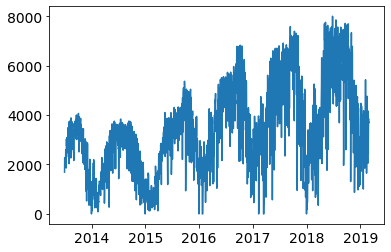

In [35]:
ax = plt.subplot()
ax.plot(df_fb['ds'], df_fb.y)
plt.show()

### Building Our Model
We'll first build a model without tuning any hyperparamters
<br>
Cross validation sets with prediction horizons of 365 days are generated every 180 days, with an initial training set of 730 days

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-09-12 00:00:00 and 2018-02-28 00:00:00


RMSE : 863.3742079205904


<Figure size 432x288 with 0 Axes>

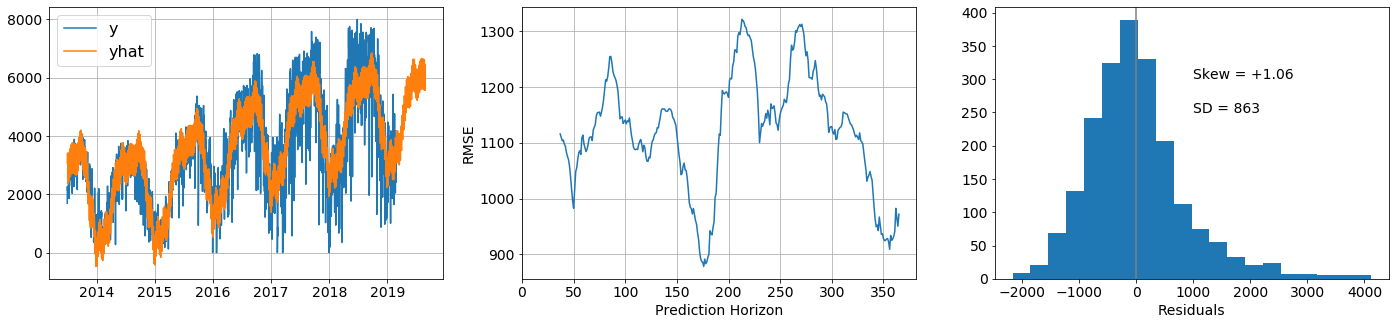

In [36]:
model = Prophet()
model.fit(df_fb)

df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics = ['rmse'])

future = model.make_future_dataframe(periods=180)
future['cap'] = 10000
future['floor'] = 0
forecast = model.predict(future)

f.m_rmse(df_fb, forecast), f.charts(df_fb, df_p, forecast);

- Model RMSE: 863
- The first chart shows how well our model fits our training data
- The second chart shows how our model performed in the cross-validation sets
- I'm not sure what to expect from a chart like this - intuitively, I'd say RMSE should be lowest for shorter prediction horizons and streadily increase the further out we project. Not sure what could explain the many peaks and will probably investigate in the future.
- Residuls shown for overall training set in the third chart

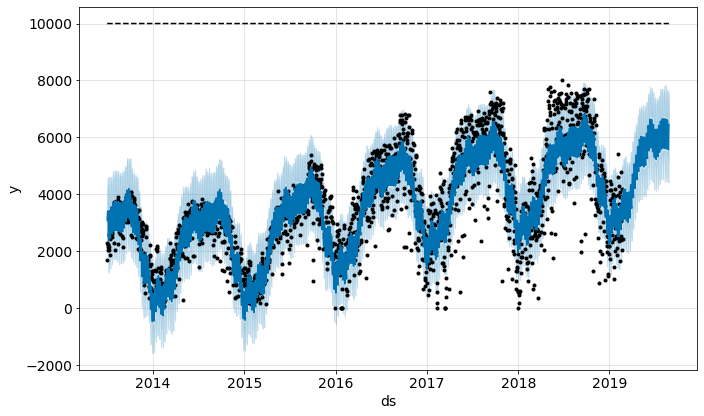

In [37]:
model.plot(forecast);

Not sure why specifying the floor isn't working to prevent our predictions from being less than zero. The cap of 10,000 is recognizeD (dashed line) but the floor of zero is not, will need to investigate in future.

### Tuning Hyperparameters
- Prophet provides functionality for tuning a variety of hyperparamters
- We'll set the changepoint_prior_scale to 2.5 (default = 0.5) to allow the model to have more flexibility

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-09-12 00:00:00 and 2018-02-28 00:00:00


RMSE : 818.1861151702062


<Figure size 432x288 with 0 Axes>

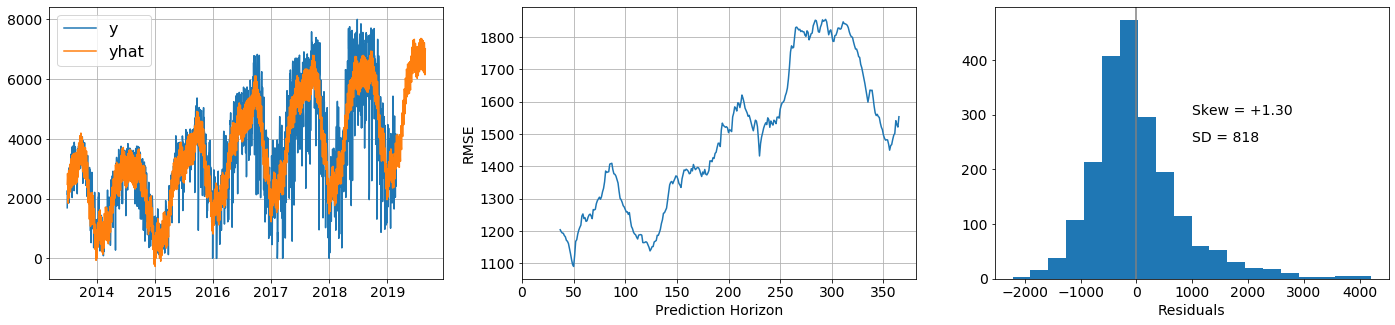

In [38]:
model = Prophet(changepoint_prior_scale = 2.5)
model.fit(df_fb)

df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics = ['rmse'])

future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

f.m_rmse(df_fb, forecast), f.charts(df_fb, df_p, forecast);

- The result is a lower RMSE - now 818 versus 863 from before
- It looks like this helped with the training data, but our cross-validation predictions have suffered
- Will not adjust this hyperparamter moving forward

### Holidays and Other Hypyerparameters
- Prophet has built-in functionality for adding national holidays. This info could be especially useful for ecommerce and other business use cases, but I suspect will not help explain much of the variation in Citi Bike daily volume.
- Prophet also allows for adjusting the trend felixibility with the 'fourier_order' argument, we'll try modeling with and without adjusting this hyperparameter <br> Good video on Fourier Series: https://www.youtube.com/watch?v=ds0cmAV-Yek

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-09-12 00:00:00 and 2018-02-28 00:00:00


RMSE : 841.8257418956885


<Figure size 432x288 with 0 Axes>

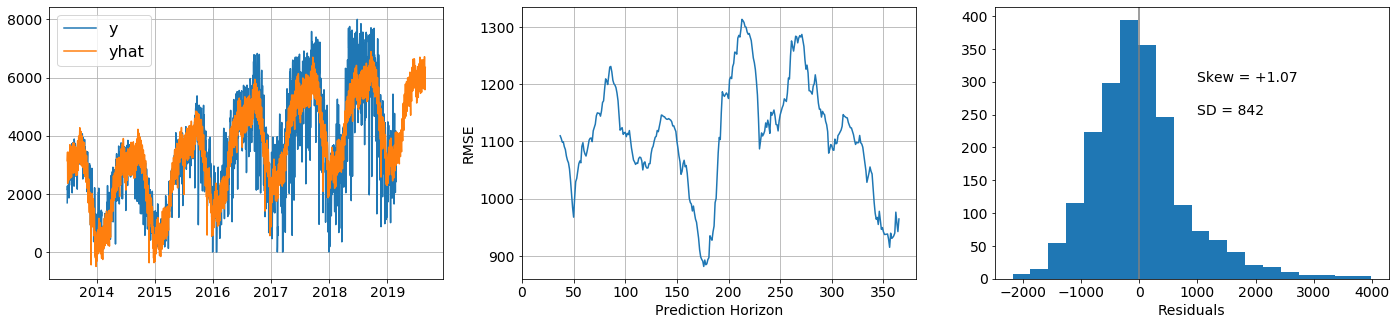

In [39]:
model = Prophet()
model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model.add_country_holidays(country_name = 'US')
model.fit(df_fb)

df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics = ['rmse'])

future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

f.m_rmse(df_fb, forecast), f.charts(df_fb, df_p, forecast);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-09-12 00:00:00 and 2018-02-28 00:00:00


RMSE : 844.9328782809059


<Figure size 432x288 with 0 Axes>

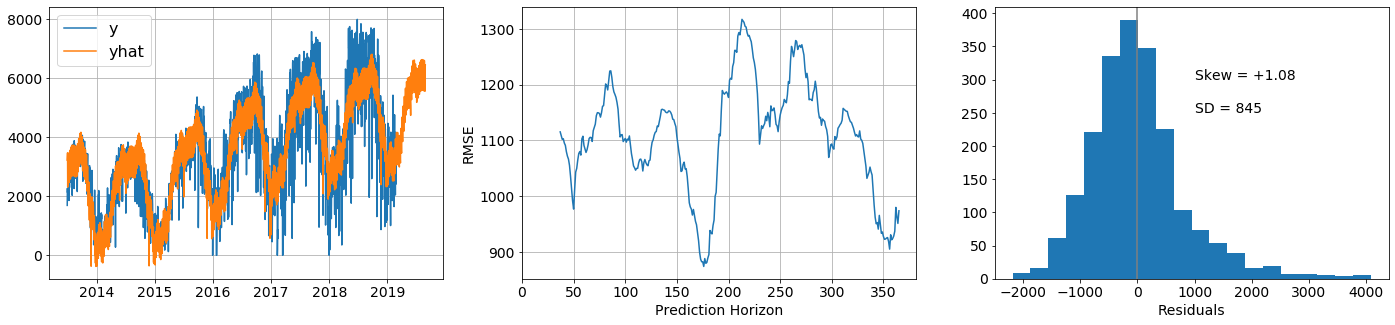

In [40]:
model = Prophet()
# model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model.add_country_holidays(country_name = 'US')
model.fit(df_fb)

df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics = ['rmse'])

future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

f.m_rmse(df_fb, forecast), f.charts(df_fb, df_p, forecast);

Our model with and without fourier_order adjusted have similar predictive power

### Adding in Weather Info

In [41]:
df_reg = df_fb.copy()
df_reg = df_reg.merge(df_w, on = 'ds', how = 'inner')
df_reg.head()

,ds,y,cap,floor,TEMP,PCP01,PCP06,PCP24,SPD,GUS,SD
0,2013-07-01,1691,10000,0,71.586207,0.030690,0.028966,0.000000,2.655172,1.310345,0.0
1,2013-07-02,2268,10000,0,72.480000,0.000400,0.000400,0.067200,2.200000,0.000000,0.0
2,2013-07-03,2127,10000,0,73.321429,0.021429,0.021429,0.005714,3.571429,0.642857,0.0
3,2013-07-04,2203,10000,0,76.400000,0.000000,0.000000,0.042400,2.720000,0.000000,0.0
4,2013-07-05,2247,10000,0,79.080000,0.000000,0.000000,0.000000,4.240000,1.480000,0.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-09-12 00:00:00 and 2018-02-28 00:00:00


RMSE : 594.6104742329596


<Figure size 432x288 with 0 Axes>

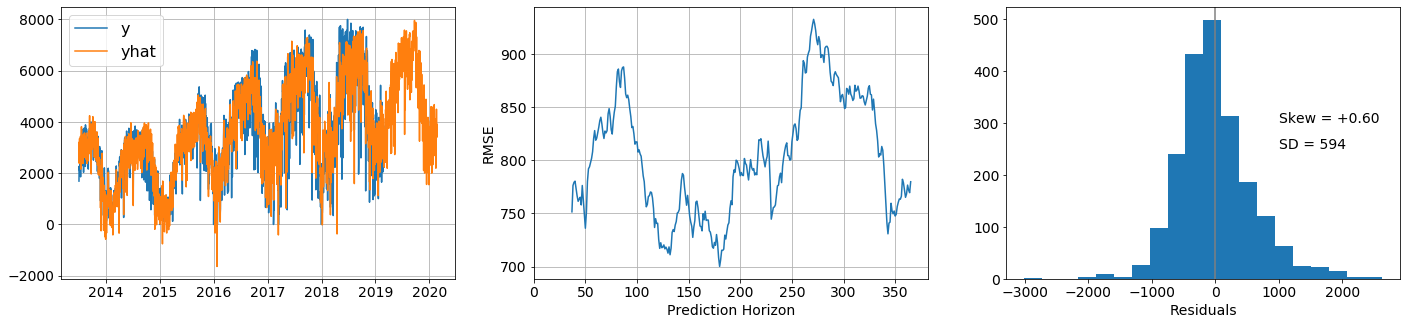

In [42]:
reg_prior = 5
reg_mode = 'multiplicative'

model = Prophet()
model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model.add_country_holidays(country_name = 'US')

model.add_regressor('TEMP', prior_scale = reg_prior, mode = reg_mode)
model.add_regressor('PCP01', prior_scale = reg_prior, mode = reg_mode)
model.add_regressor('SPD', prior_scale = reg_prior, mode = reg_mode)
model.add_regressor('SD', prior_scale = reg_prior, mode = reg_mode)

model.fit(df_reg)

df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics = ['rmse'])

future = model.make_future_dataframe(periods=360)
future = future.merge(df_w, on = 'ds', how = 'inner')

forecast = model.predict(future)

f.m_rmse(df_reg, forecast), f.charts(df_reg, df_p, forecast);

- We can see that adding the weather regressors gave the model much more flexibility and predictive power:
- The RMSE decreased by 31% (598 vs. 863)
- Our cross-validation projections are now generally lower: max < 1000 versus max > 1300 in original model
- Residual skew & variance have decreased

### Adding Weather Regressors to Our Holdout Set

In [43]:
df_ho = df_ho.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on = 'ds', how = 'inner')
ho_rmse = np.sqrt(np.mean((df_ho.yhat - df_ho.y) ** 2))

print(f'holdout set rmse: {ho_rmse}')

holdout set rmse: 1150.9780634399262


RMSE in holdout set is ~2x training set RMSE 👎

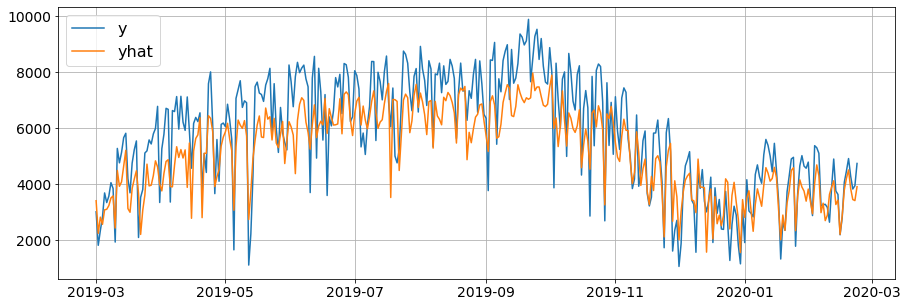

In [44]:
plt.figure(figsize = (15, 5))
plt.plot(df_ho.ds, df_ho.y, label = 'y')
plt.plot(df_ho.ds, df_ho.yhat, label = 'yhat')
plt.grid(True)
plt.legend(loc = 'upper left', fancybox = True, prop = {'size' : 16});

### Investigating Holdout Set Performance
Calculating running 7-day average for RMSE and residuals

In [45]:
running_rmse = []
for i in range(7, 360):
    d = df_ho.iloc[i].ds
    r = np.sqrt(np.mean((df_ho[i - 7:i + 1].yhat - df_ho[i - 7:i + 1].y) ** 2))
    
    running_rmse.append({'ds' : d, 'rmse' : r})
rmse_df = pd.DataFrame(running_rmse)  
rmse_df['ds'] = pd.to_datetime(rmse_df['ds'])

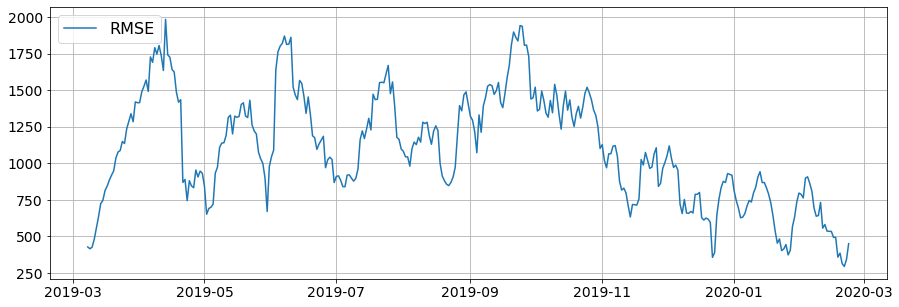

In [46]:
plt.figure(figsize = (15, 5))
plt.plot(rmse_df.ds, rmse_df.rmse, label = 'RMSE')
plt.grid(True)
plt.legend(loc = 'upper left', fancybox = True, prop = {'size' : 16});

RMSE is highest during the warmer months, would need to do more research to determine what the model is missing

In [47]:
running_res = []
for i in range(7, 360):
    d = df_ho.iloc[i].ds
    r = np.mean((df_ho[i - 7:i + 1].yhat - df_ho[i - 7:i + 1].y))
    
    running_res.append({'ds' : d, 'residuals' : r})
res_df = pd.DataFrame(running_res)  
res_df['ds'] = pd.to_datetime(res_df['ds'])

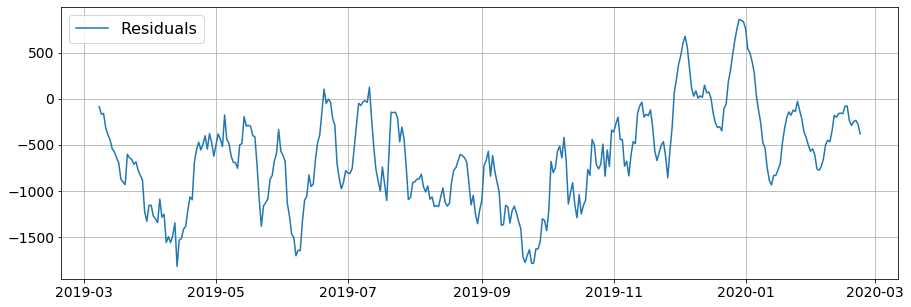

In [48]:
plt.figure(figsize = (15, 5))
plt.plot(res_df.ds, res_df.residuals , label = 'Residuals')
plt.grid(True)
plt.legend(loc = 'upper left', fancybox = True, prop = {'size' : 16});

Specifically, the model is under-predicting during the warmer months and random-ish about zero after the Fall time

# Future Learnings:

- What's going on with the holdout set? & how to correct for seasonality in RMSE
- Get the prediction floor to work properly

Side note: Prophet gives the option for MCMC, but the simulations take FOREVER and I found the models to have similar predictive power

# Commuters
Future work: Create map similar to below-linked Dash App to highlight where commuters are traveling to / from with slider for time of day

https://dash-gallery.plotly.host/dash-uber-rides-demo/